# Entropy Convergence Analysis

Comparing basic_entropy_sum vs diag_rb_entropy_sum convergence with batch size.

**Research Question**: Does RB entropy provide better (lower variance) estimates than basic entropy?

In [21]:
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Load the data
data_file = "data/entropy_study_2.json"
print(f"Loading data from: {data_file}")

with open(data_file, 'r') as f:
    results = json.load(f)

print(f"Loaded {len(results['per_sequence_data'])} sequences")
print(f"Experiment info: {results['experiment_info']}")

Loading data from: data/entropy_study_2.json
Loaded 4096 sequences
Experiment info: {'experiment_type': 'entropy_reward_study', 'checkpoint_path': '/content/drive/MyDrive/RL_Practice_Files/new_rl_checkpoint/step_60/model', 'num_prompts': 4096, 'G': 1, 'dataset': 'gsm8k_r1_template', 'split': 'train', 'generation_params': {'temperature': 0.7, 'top_p': 1.0, 'max_new_tokens': 200, 'gen_batch_size': 64, 'tf_batch_size': 64}}


## Data Inspection

Let's first understand what we're working with and check for data quality issues.

In [22]:
# Extract per-sequence data
per_seq_data = results['per_sequence_data']
df = pd.DataFrame(per_seq_data)

print("Dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nFirst few rows:")
df.head()

Dataset shape: (4096, 28)

Columns: ['prompt_idx', 'generation_idx', 'response_text', 'response_length_tokens', 'prompt_length_tokens', 'basic_entropy_mean', 'basic_entropy_sum', 'rb_entropy_mean', 'rb_entropy_sum', 'entropy_reduction', 'sequence_logprob', 'reward', 'diag_T', 'diag_rb_entropy_sum', 'diag_rb_entropy_mean', 'diag_rb_entropy_max', 'diag_rb_entropy_min', 'diag_early_rb_entropy_mean', 'diag_late_rb_entropy_mean', 'diag_naive_surprisal_sum', 'diag_naive_surprisal_mean', 'diag_margin_mean', 'diag_margin_sum', 'diag_top1_prob_mean', 'diag_collision_mean', 'diag_renyi2_mean', 'diag_eff_support_mean', 'diag_eos_prob_mean']

First few rows:


,prompt_idx,generation_idx,response_text,response_length_tokens,prompt_length_tokens,basic_entropy_mean,basic_entropy_sum,rb_entropy_mean,rb_entropy_sum,entropy_reduction,...,diag_late_rb_entropy_mean,diag_naive_surprisal_sum,diag_naive_surprisal_mean,diag_margin_mean,diag_margin_sum,diag_top1_prob_mean,diag_collision_mean,diag_renyi2_mean,diag_eff_support_mean,diag_eos_prob_mean
0,0,0,Marcus got a discount of $120 \times \frac{30...,98,204,0.234952,23.025259,0.250000,24.500,-0.015048,...,0.222656,23.025259,0.234952,7.65625,752.0,0.914062,0.882812,0.171875,1.468750,3.274181e-09
1,1,0,Charlene is 62 / 2 = 31 centimeters tall.\nPa...,89,204,0.109972,9.787476,0.109551,9.750,0.000421,...,0.075195,9.787476,0.109972,9.00000,800.0,0.960938,0.945312,0.071777,1.171875,1.979060e-09
2,2,0,"If New England has 2100000 people, then New Yo...",120,204,0.167442,20.093090,0.155208,18.625,0.012234,...,0.141602,20.093088,0.167442,9.18750,1104.0,0.945312,0.921875,0.105957,1.242188,7.962808e-08
3,3,0,"In one year, Elias uses 1 bar of soap. So, in ...",72,204,0.218959,15.765062,0.239583,17.250,-0.020624,...,0.145508,15.765063,0.218959,7.18750,520.0,0.910156,0.882812,0.169922,1.445312,2.328306e-08
4,4,0,The total price of the items is 120 + 19 = 13...,97,204,0.328169,31.832397,0.264175,25.625,0.063994,...,0.244141,31.832399,0.328169,6.93750,672.0,0.910156,0.871094,0.175781,1.468750,1.257285e-08


In [25]:
# Check for data quality issues
print("=== DATA QUALITY CHECKS ===")
print(f"Total sequences: {len(df)}")
print(f"Missing basic_entropy_sum: {df['basic_entropy_sum'].isna().sum()}")
print(f"Missing diag_rb_entropy_sum: {df['diag_rb_entropy_sum'].isna().sum()}")
print(f"Zero basic_entropy_sum: {(df['basic_entropy_sum'] == 0).sum()}")
print(f"Zero diag_rb_entropy_sum: {(df['diag_rb_entropy_sum'] == 0).sum()}")
print(f"Very small basic_entropy_sum (<0.01): {(df['basic_entropy_sum'] < 0.01).sum()}")
print(f"Very small diag_rb_entropy_sum (<0.01): {(df['diag_rb_entropy_sum'] < 0.01).sum()}")

print("\n=== BASIC ENTROPY STATISTICS ===")
print(df['basic_entropy_sum'].describe())

print("\n=== RB ENTROPY STATISTICS ===")
print(df['diag_rb_entropy_sum'].describe())

=== DATA QUALITY CHECKS ===
Total sequences: 4096
Missing basic_entropy_sum: 0
Missing diag_rb_entropy_sum: 0
Zero basic_entropy_sum: 0
Zero diag_rb_entropy_sum: 0
Very small basic_entropy_sum (<0.01): 0
Very small diag_rb_entropy_sum (<0.01): 0

=== BASIC ENTROPY STATISTICS ===
count    4096.000000
mean       26.470492
std        14.304425
min         2.668291
25%        16.187562
50%        23.458675
75%        33.586483
max       146.807373
Name: basic_entropy_sum, dtype: float64

=== RB ENTROPY STATISTICS ===
count    4096.000000
mean       23.563721
std        11.674227
min         3.750000
25%        15.125000
50%        21.250000
75%        29.375000
max       112.000000
Name: diag_rb_entropy_sum, dtype: float64


In [26]:
# Check if data is shuffled or ordered
print("=== DATA ORDERING CHECK ===")
print("First 10 basic entropy values:")
print(df['basic_entropy_sum'].head(10).tolist())
print("\nLast 10 basic entropy values:")
print(df['basic_entropy_sum'].tail(10).tolist())

# Check correlation between index and entropy (would indicate ordering)
index_corr_basic = np.corrcoef(range(len(df)), df['basic_entropy_sum'])[0,1]
index_corr_rb = np.corrcoef(range(len(df)), df['diag_rb_entropy_sum'])[0,1]
print(f"\nCorrelation between index and basic entropy: {index_corr_basic:.4f}")
print(f"Correlation between index and RB entropy: {index_corr_rb:.4f}")
if abs(index_corr_basic) > 0.1 or abs(index_corr_rb) > 0.1:
    print("⚠️ WARNING: Data might be ordered, which could affect batch analysis!")

=== DATA ORDERING CHECK ===
First 10 basic entropy values:
[23.025259017944336, 9.7874755859375, 20.093090057373047, 15.76506233215332, 31.8323974609375, 33.754459381103516, 16.63144302368164, 7.725907325744629, 9.595195770263672, 23.8566951751709]

Last 10 basic entropy values:
[6.144504070281982, 30.78717803955078, 23.293867111206055, 13.850356101989746, 25.94469451904297, 30.738910675048828, 13.0916109085083, 14.484092712402344, 7.620667457580566, 28.455486297607422]

Correlation between index and basic entropy: -0.0117
Correlation between index and RB entropy: -0.0113


## Batch Convergence Analysis

Now let's carefully implement the batch convergence analysis, being explicit about what we're computing.

In [27]:
def analyze_convergence_with_random_sampling(basic_vals, rb_vals, sample_sizes, n_samples=1000, seed=42):
    """
    Analyze convergence using random subsampling (the correct approach).
    
    For each sample size B:
    1. Draw n_samples random subsets of size B (without replacement)
    2. Compute mean of each subset
    3. Analyze distribution of these sample means
    
    The key insight:
    - Sample means should vary around the overall mean
    - Std of sample means should decrease as 1/√B (central limit theorem)
    - RB entropy should have lower variance than basic entropy (variance reduction)
    """
    
    np.random.seed(seed)
    N = len(basic_vals)
    
    # Overall statistics for reference
    overall_basic_mean = np.mean(basic_vals)
    overall_basic_std = np.std(basic_vals)
    overall_rb_mean = np.mean(rb_vals)
    overall_rb_std = np.std(rb_vals)
    
    print(f"Total samples: {N}")
    print(f"Overall basic entropy: mean={overall_basic_mean:.4f}, std={overall_basic_std:.4f}")
    print(f"Overall RB entropy: mean={overall_rb_mean:.4f}, std={overall_rb_std:.4f}")
    print(f"Drawing {n_samples} random subsets for each sample size")
    print()
    
    results = []
    
    for B in sample_sizes:
        if B >= N:
            print(f"Sample size B={B}: Skipping (larger than dataset)")
            continue
            
        print(f"Sample size B={B}:")
        
        # Draw random subsets and compute means
        basic_sample_means = []
        rb_sample_means = []
        
        for i in range(n_samples):
            # Random sampling without replacement
            subset_indices = np.random.choice(N, size=B, replace=False)
            
            basic_subset_mean = np.mean(basic_vals[subset_indices])
            rb_subset_mean = np.mean(rb_vals[subset_indices])
            
            basic_sample_means.append(basic_subset_mean)
            rb_sample_means.append(rb_subset_mean)
        
        basic_sample_means = np.array(basic_sample_means)
        rb_sample_means = np.array(rb_sample_means)
        
        # Statistics of the sample means
        basic_mean_of_means = np.mean(basic_sample_means)
        basic_std_of_means = np.std(basic_sample_means, ddof=1)
        
        rb_mean_of_means = np.mean(rb_sample_means)
        rb_std_of_means = np.std(rb_sample_means, ddof=1)
        
        # Theoretical expectations (central limit theorem)
        basic_expected_std = overall_basic_std / np.sqrt(B)
        rb_expected_std = overall_rb_std / np.sqrt(B)
        
        # Variance reduction
        var_reduction = (basic_std_of_means**2 - rb_std_of_means**2) / basic_std_of_means**2 * 100
        
        print(f"  Basic entropy:")
        print(f"    Mean of sample means: {basic_mean_of_means:.6f} (overall: {overall_basic_mean:.6f})")
        print(f"    Std of sample means: {basic_std_of_means:.6f} (expected: {basic_expected_std:.6f})")
        print(f"  RB entropy:")
        print(f"    Mean of sample means: {rb_mean_of_means:.6f} (overall: {overall_rb_mean:.6f})")
        print(f"    Std of sample means: {rb_std_of_means:.6f} (expected: {rb_expected_std:.6f})")
        print(f"  Variance reduction: {var_reduction:.1f}%")
        print(f"  Standard error: Basic={basic_std_of_means/np.sqrt(n_samples):.6f}, RB={rb_std_of_means/np.sqrt(n_samples):.6f}")
        print()
        
        results.append({
            'sample_size': B,
            'n_samples': n_samples,
            'basic_mean_of_means': basic_mean_of_means,
            'basic_std_of_means': basic_std_of_means,
            'basic_expected_std': basic_expected_std,
            'rb_mean_of_means': rb_mean_of_means,
            'rb_std_of_means': rb_std_of_means,
            'rb_expected_std': rb_expected_std,
            'var_reduction': var_reduction,
            'basic_sample_means': basic_sample_means.copy(),
            'rb_sample_means': rb_sample_means.copy()
        })
    
    return results

# Run the analysis with extended sample sizes for larger datasets
basic_entropies = df['basic_entropy_sum'].values
rb_entropies = df['diag_rb_entropy_sum'].values

# All powers of 2 from 32 up to 2048 (for datasets up to 4096 samples)
sample_sizes = [32, 64, 128, 256, 512, 1024, 2048]

print("=== RANDOM SUBSAMPLING CONVERGENCE ANALYSIS ===")
print(f"Sample sizes to test: {sample_sizes}")
print(f"Maximum sample size: {max(sample_sizes)} (dataset size: {len(basic_entropies)})")
print()

results = analyze_convergence_with_random_sampling(basic_entropies, rb_entropies, sample_sizes)

=== RANDOM SUBSAMPLING CONVERGENCE ANALYSIS ===
Sample sizes to test: [32, 64, 128, 256, 512, 1024, 2048]
Maximum sample size: 2048 (dataset size: 4096)

Total samples: 4096
Overall basic entropy: mean=26.4705, std=14.3027
Overall RB entropy: mean=23.5637, std=11.6728
Drawing 1000 random subsets for each sample size

Sample size B=32:
  Basic entropy:
    Mean of sample means: 26.488090 (overall: 26.470492)
    Std of sample means: 2.476759 (expected: 2.528380)
  RB entropy:
    Mean of sample means: 23.577637 (overall: 23.563721)
    Std of sample means: 2.027587 (expected: 2.063479)
  Variance reduction: 33.0%
  Standard error: Basic=0.078322, RB=0.064118

Sample size B=64:
  Basic entropy:
    Mean of sample means: 26.526537 (overall: 26.470492)
    Std of sample means: 1.789689 (expected: 1.787835)
  RB entropy:
    Mean of sample means: 23.600172 (overall: 23.563721)
    Std of sample means: 1.443994 (expected: 1.459100)
  Variance reduction: 34.9%
  Standard error: Basic=0.056595

## Visualization

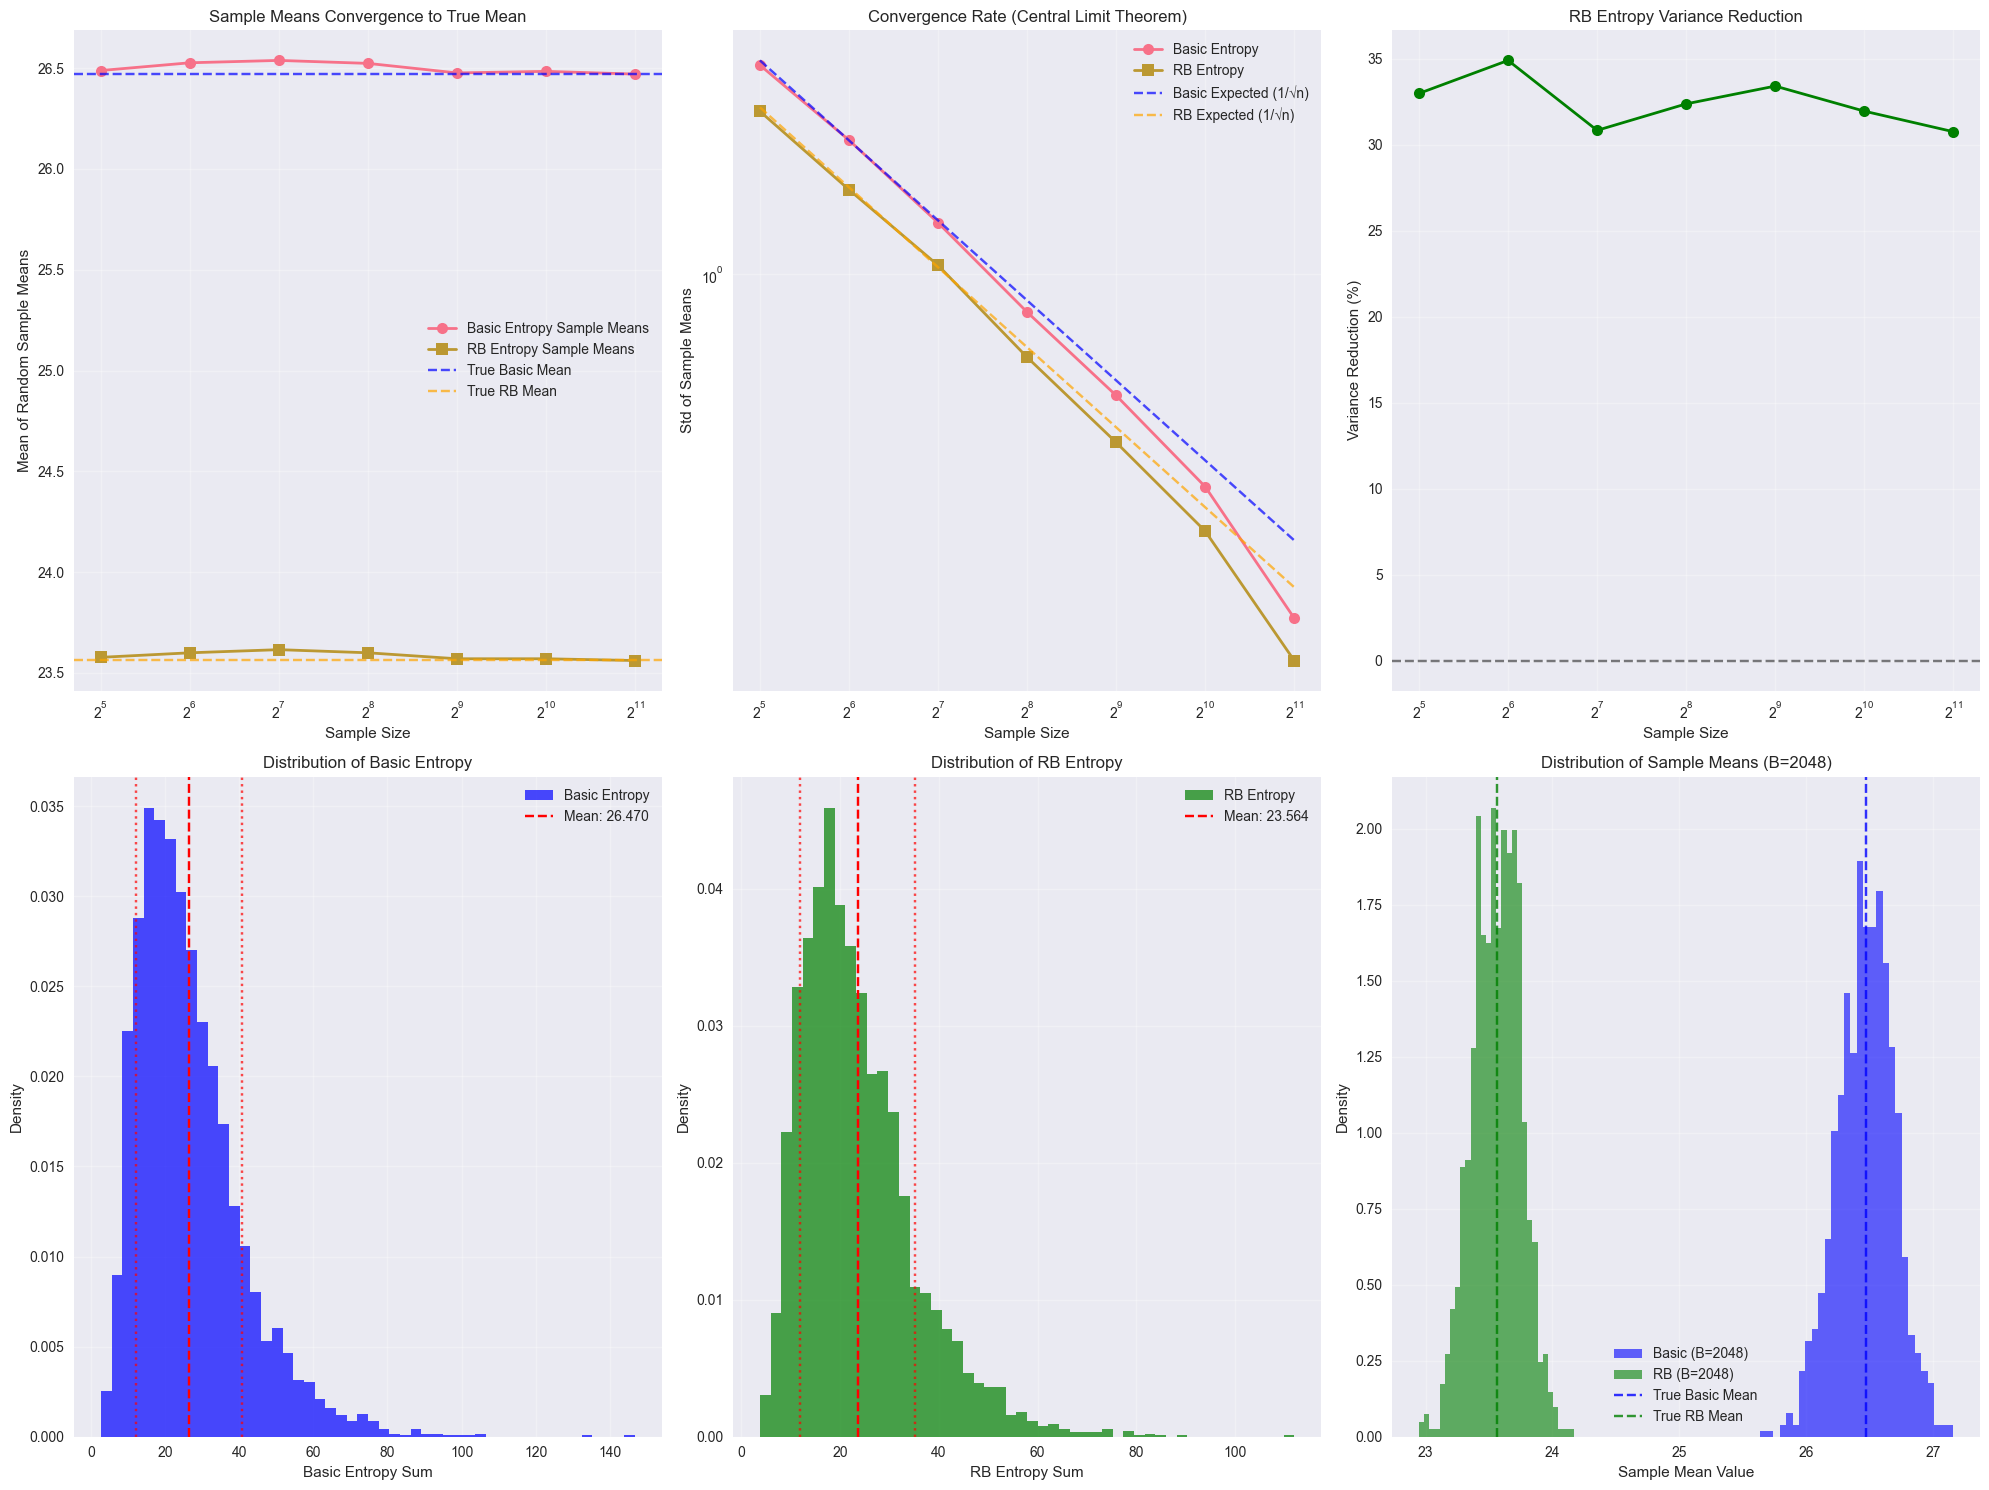

In [28]:
# Create comprehensive plots
fig = plt.figure(figsize=(20, 15))

# Extract data from results
sample_sizes_plot = [r['sample_size'] for r in results]
basic_means = [r['basic_mean_of_means'] for r in results]
rb_means = [r['rb_mean_of_means'] for r in results]
basic_stds = [r['basic_std_of_means'] for r in results]
rb_stds = [r['rb_std_of_means'] for r in results]

# Plot 1: Sample means convergence around true means
ax1 = plt.subplot(2, 3, 1)
plt.plot(sample_sizes_plot, basic_means, 'o-', label='Basic Entropy Sample Means', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_means, 's-', label='RB Entropy Sample Means', linewidth=2, markersize=8)
plt.axhline(np.mean(basic_entropies), color='blue', linestyle='--', alpha=0.7, label='True Basic Mean')
plt.axhline(np.mean(rb_entropies), color='orange', linestyle='--', alpha=0.7, label='True RB Mean')
plt.xlabel('Sample Size')
plt.ylabel('Mean of Random Sample Means')
plt.title('Sample Means Convergence to True Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 2: Standard deviation convergence (1/√n behavior)
ax2 = plt.subplot(2, 3, 2)
plt.plot(sample_sizes_plot, basic_stds, 'o-', label='Basic Entropy', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_stds, 's-', label='RB Entropy', linewidth=2, markersize=8)

# Add theoretical 1/√n lines
basic_expected_stds = [r['basic_expected_std'] for r in results]
rb_expected_stds = [r['rb_expected_std'] for r in results]
plt.plot(sample_sizes_plot, basic_expected_stds, '--', color='blue', alpha=0.7, label='Basic Expected (1/√n)')
plt.plot(sample_sizes_plot, rb_expected_stds, '--', color='orange', alpha=0.7, label='RB Expected (1/√n)')

plt.xlabel('Sample Size')
plt.ylabel('Std of Sample Means')
plt.title('Convergence Rate (Central Limit Theorem)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.yscale('log')

# Plot 3: Variance reduction
ax3 = plt.subplot(2, 3, 3)
var_reductions = [r['var_reduction'] for r in results]
plt.plot(sample_sizes_plot, var_reductions, 'o-', color='green', linewidth=2, markersize=8)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.xlabel('Sample Size')
plt.ylabel('Variance Reduction (%)')
plt.title('RB Entropy Variance Reduction')
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 4: Distribution of basic entropies
ax4 = plt.subplot(2, 3, 4)
plt.hist(basic_entropies, bins=50, alpha=0.7, density=True, color='blue', label='Basic Entropy')
mean_basic = np.mean(basic_entropies)
std_basic = np.std(basic_entropies)
plt.axvline(mean_basic, color='red', linestyle='--', label=f'Mean: {mean_basic:.3f}')
plt.axvline(mean_basic + std_basic, color='red', linestyle=':', alpha=0.7)
plt.axvline(mean_basic - std_basic, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Basic Entropy Sum')
plt.ylabel('Density')
plt.title('Distribution of Basic Entropy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Distribution of RB entropies
ax5 = plt.subplot(2, 3, 5)
plt.hist(rb_entropies, bins=50, alpha=0.7, density=True, color='green', label='RB Entropy')
mean_rb = np.mean(rb_entropies)
std_rb = np.std(rb_entropies)
plt.axvline(mean_rb, color='red', linestyle='--', label=f'Mean: {mean_rb:.3f}')
plt.axvline(mean_rb + std_rb, color='red', linestyle=':', alpha=0.7)
plt.axvline(mean_rb - std_rb, color='red', linestyle=':', alpha=0.7)
plt.xlabel('RB Entropy Sum')
plt.ylabel('Density')
plt.title('Distribution of RB Entropy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Sample means distributions for largest sample size (most precise)
ax6 = plt.subplot(2, 3, 6)
largest_result = results[-1]  # Should be B=512
basic_sample_means = largest_result['basic_sample_means']
rb_sample_means = largest_result['rb_sample_means']

plt.hist(basic_sample_means, bins=30, alpha=0.6, density=True, color='blue', label=f'Basic (B={largest_result["sample_size"]})')
plt.hist(rb_sample_means, bins=30, alpha=0.6, density=True, color='green', label=f'RB (B={largest_result["sample_size"]})')
plt.axvline(np.mean(basic_entropies), color='blue', linestyle='--', alpha=0.8, label='True Basic Mean')
plt.axvline(np.mean(rb_entropies), color='green', linestyle='--', alpha=0.8, label='True RB Mean')
plt.xlabel('Sample Mean Value')
plt.ylabel('Density')
plt.title(f'Distribution of Sample Means (B={largest_result["sample_size"]})')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Create comprehensive plots for extended analysis
fig = plt.figure(figsize=(24, 16))

# Extract data from results
sample_sizes_plot = [r['sample_size'] for r in results]
basic_means = [r['basic_mean_of_means'] for r in results]
rb_means = [r['rb_mean_of_means'] for r in results]
basic_stds = [r['basic_std_of_means'] for r in results]
rb_stds = [r['rb_std_of_means'] for r in results]

print(f"Plotting results for {len(sample_sizes_plot)} sample sizes: {sample_sizes_plot}")

# Plot 1: Sample means convergence around true means
ax1 = plt.subplot(3, 3, 1)
plt.plot(sample_sizes_plot, basic_means, 'o-', label='Basic Entropy Sample Means', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_means, 's-', label='RB Entropy Sample Means', linewidth=2, markersize=8)
plt.axhline(np.mean(basic_entropies), color='blue', linestyle='--', alpha=0.7, label='True Basic Mean')
plt.axhline(np.mean(rb_entropies), color='orange', linestyle='--', alpha=0.7, label='True RB Mean')
plt.xlabel('Sample Size')
plt.ylabel('Mean of Random Sample Means')
plt.title('Sample Means Convergence to True Mean')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 2: Standard deviation convergence (1/√n behavior)
ax2 = plt.subplot(3, 3, 2)
plt.plot(sample_sizes_plot, basic_stds, 'o-', label='Basic Entropy', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_stds, 's-', label='RB Entropy', linewidth=2, markersize=8)

# Add theoretical 1/√n lines
basic_expected_stds = [r['basic_expected_std'] for r in results]
rb_expected_stds = [r['rb_expected_std'] for r in results]
plt.plot(sample_sizes_plot, basic_expected_stds, '--', color='blue', alpha=0.7, label='Basic Expected (1/√n)')
plt.plot(sample_sizes_plot, rb_expected_stds, '--', color='orange', alpha=0.7, label='RB Expected (1/√n)')

plt.xlabel('Sample Size')
plt.ylabel('Std of Sample Means')
plt.title('Convergence Rate (Central Limit Theorem)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.yscale('log')

# Plot 3: Variance reduction
ax3 = plt.subplot(3, 3, 3)
var_reductions = [r['var_reduction'] for r in results]
plt.plot(sample_sizes_plot, var_reductions, 'o-', color='green', linewidth=2, markersize=8)
plt.axhline(0, color='black', linestyle='--', alpha=0.5)
plt.axhline(np.mean(var_reductions), color='green', linestyle=':', alpha=0.7, label=f'Average: {np.mean(var_reductions):.1f}%')
plt.xlabel('Sample Size')
plt.ylabel('Variance Reduction (%)')
plt.title('RB Entropy Variance Reduction')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 4: Distribution of basic entropies
ax4 = plt.subplot(3, 3, 4)
plt.hist(basic_entropies, bins=50, alpha=0.7, density=True, color='blue', label='Basic Entropy')
mean_basic = np.mean(basic_entropies)
std_basic = np.std(basic_entropies)
plt.axvline(mean_basic, color='red', linestyle='--', label=f'Mean: {mean_basic:.3f}')
plt.axvline(mean_basic + std_basic, color='red', linestyle=':', alpha=0.7)
plt.axvline(mean_basic - std_basic, color='red', linestyle=':', alpha=0.7)
plt.xlabel('Basic Entropy Sum')
plt.ylabel('Density')
plt.title('Distribution of Basic Entropy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 5: Distribution of RB entropies
ax5 = plt.subplot(3, 3, 5)
plt.hist(rb_entropies, bins=50, alpha=0.7, density=True, color='green', label='RB Entropy')
mean_rb = np.mean(rb_entropies)
std_rb = np.std(rb_entropies)
plt.axvline(mean_rb, color='red', linestyle='--', label=f'Mean: {mean_rb:.3f}')
plt.axvline(mean_rb + std_rb, color='red', linestyle=':', alpha=0.7)
plt.axvline(mean_rb - std_rb, color='red', linestyle=':', alpha=0.7)
plt.xlabel('RB Entropy Sum')
plt.ylabel('Density')
plt.title('Distribution of RB Entropy')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 6: Sample means distributions for largest sample size (most precise)
ax6 = plt.subplot(3, 3, 6)
if results:  # Check if we have results
    largest_result = results[-1]  # Should be the largest valid sample size
    basic_sample_means = largest_result['basic_sample_means']
    rb_sample_means = largest_result['rb_sample_means']

    plt.hist(basic_sample_means, bins=30, alpha=0.6, density=True, color='blue', label=f'Basic (B={largest_result["sample_size"]})')
    plt.hist(rb_sample_means, bins=30, alpha=0.6, density=True, color='green', label=f'RB (B={largest_result["sample_size"]})')
    plt.axvline(np.mean(basic_entropies), color='blue', linestyle='--', alpha=0.8, label='True Basic Mean')
    plt.axvline(np.mean(rb_entropies), color='green', linestyle='--', alpha=0.8, label='True RB Mean')
    plt.xlabel('Sample Mean Value')
    plt.ylabel('Density')
    plt.title(f'Distribution of Sample Means (B={largest_result["sample_size"]})')
    plt.legend()
plt.grid(True, alpha=0.3)

# Plot 7: Ratio of observed/expected standard deviations
ax7 = plt.subplot(3, 3, 7)
basic_ratios = [r['basic_std_of_means'] / r['basic_expected_std'] for r in results]
rb_ratios = [r['rb_std_of_means'] / r['rb_expected_std'] for r in results]
plt.plot(sample_sizes_plot, basic_ratios, 'o-', label='Basic Entropy', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_ratios, 's-', label='RB Entropy', linewidth=2, markersize=8)
plt.axhline(1.0, color='black', linestyle='--', alpha=0.5, label='Perfect CLT (ratio=1.0)')
plt.xlabel('Sample Size')
plt.ylabel('Observed/Expected Std Ratio')
plt.title('Central Limit Theorem Validation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)

# Plot 8: Log-log plot of standard deviation vs sample size (should be straight line with slope -0.5)
ax8 = plt.subplot(3, 3, 8)
plt.loglog(sample_sizes_plot, basic_stds, 'o-', label='Basic Entropy', linewidth=2, markersize=8, base=2)
plt.loglog(sample_sizes_plot, rb_stds, 's-', label='RB Entropy', linewidth=2, markersize=8, base=2)
plt.loglog(sample_sizes_plot, basic_expected_stds, '--', color='blue', alpha=0.7, label='Basic Expected', base=2)
plt.loglog(sample_sizes_plot, rb_expected_stds, '--', color='orange', alpha=0.7, label='RB Expected', base=2)
plt.xlabel('Sample Size')
plt.ylabel('Std of Sample Means')
plt.title('Log-Log: 1/√n Convergence')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 9: Error in sample means (deviation from true population mean)
ax9 = plt.subplot(3, 3, 9)
overall_basic_mean = np.mean(basic_entropies)
overall_rb_mean = np.mean(rb_entropies)
basic_errors = [abs(r['basic_mean_of_means'] - overall_basic_mean) for r in results]
rb_errors = [abs(r['rb_mean_of_means'] - overall_rb_mean) for r in results]
basic_ses = [r['basic_std_of_means'] / np.sqrt(r['n_samples']) for r in results]
rb_ses = [r['rb_std_of_means'] / np.sqrt(r['n_samples']) for r in results]

plt.plot(sample_sizes_plot, basic_errors, 'o-', label='Basic Entropy', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, rb_errors, 's-', label='RB Entropy', linewidth=2, markersize=8)
plt.plot(sample_sizes_plot, basic_ses, '--', color='blue', alpha=0.7, label='Basic SE')
plt.plot(sample_sizes_plot, rb_ses, '--', color='orange', alpha=0.7, label='RB SE')
plt.xlabel('Sample Size')
plt.ylabel('Absolute Error in Mean Estimation')
plt.title('Accuracy of Sample Mean Estimates')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xscale('log', base=2)
plt.yscale('log')

plt.tight_layout()
plt.show()

In [20]:
print("=== FINAL SUMMARY ===")
print(f"Total sequences analyzed: {len(df)}")
print(f"Basic entropy: mean={np.mean(basic_entropies):.4f}, std={np.std(basic_entropies):.4f}")
print(f"RB entropy: mean={np.mean(rb_entropies):.4f}, std={np.std(rb_entropies):.4f}")
print(f"Correlation: {np.corrcoef(basic_entropies, rb_entropies)[0,1]:.4f}")
print()

print("Variance reduction by sample size (using random subsampling):")
for r in results:
    basic_ratio = r['basic_std_of_means'] / r['basic_expected_std']
    rb_ratio = r['rb_std_of_means'] / r['rb_expected_std']
    print(f"  B={r['sample_size']:>3}: Reduction={r['var_reduction']:>6.1f}% | Basic std: {r['basic_std_of_means']:.4f} (ratio: {basic_ratio:.3f}) | RB std: {r['rb_std_of_means']:.4f} (ratio: {rb_ratio:.3f})")

print()
avg_var_reduction = np.mean([r['var_reduction'] for r in results])
print(f"Average variance reduction: {avg_var_reduction:.1f}%")

if avg_var_reduction > 30:
    print("✅ RB entropy shows significant variance reduction!")
elif avg_var_reduction > 10:
    print("⚠️ RB entropy shows moderate variance reduction.")
else:
    print("❌ RB entropy shows minimal variance reduction.")

print(f"\n=== CENTRAL LIMIT THEOREM VALIDATION ===")
print("Observed vs Expected standard deviations (should be close to 1.0):")
for r in results:
    basic_ratio = r['basic_std_of_means'] / r['basic_expected_std']
    rb_ratio = r['rb_std_of_means'] / r['rb_expected_std']
    print(f"  B={r['sample_size']:>3}: Basic ratio={basic_ratio:.3f}, RB ratio={rb_ratio:.3f}")

# Check convergence to true means
print(f"\n=== CONVERGENCE TO TRUE MEANS ===")
print("Sample means should converge to true population means:")
overall_basic_mean = np.mean(basic_entropies)
overall_rb_mean = np.mean(rb_entropies)
for r in results:
    basic_error = abs(r['basic_mean_of_means'] - overall_basic_mean)
    rb_error = abs(r['rb_mean_of_means'] - overall_rb_mean)
    basic_se = r['basic_std_of_means'] / np.sqrt(r['n_samples'])
    rb_se = r['rb_std_of_means'] / np.sqrt(r['n_samples'])
    print(f"  B={r['sample_size']:>3}: Basic error={basic_error:.4f} (SE: {basic_se:.4f}) | RB error={rb_error:.4f} (SE: {rb_se:.4f})")

=== FINAL SUMMARY ===
Total sequences analyzed: 4096
Basic entropy: mean=51.1817, std=32.3795
RB entropy: mean=52.1515, std=30.1272
Correlation: 0.9653

Variance reduction by sample size (using random subsampling):
  B= 32: Reduction=  13.5% | Basic std: 5.6550 (ratio: 0.988) | RB std: 5.2592 (ratio: 0.988)
  B= 64: Reduction=  14.9% | Basic std: 4.1640 (ratio: 1.029) | RB std: 3.8403 (ratio: 1.020)
  B=128: Reduction=  12.9% | Basic std: 2.7421 (ratio: 0.958) | RB std: 2.5597 (ratio: 0.961)
  B=256: Reduction=  12.1% | Basic std: 1.9971 (ratio: 0.987) | RB std: 1.8723 (ratio: 0.994)
  B=512: Reduction=  14.1% | Basic std: 1.3507 (ratio: 0.944) | RB std: 1.2521 (ratio: 0.940)
  B=1024: Reduction=  14.0% | Basic std: 0.8964 (ratio: 0.886) | RB std: 0.8314 (ratio: 0.883)
  B=2048: Reduction=  14.8% | Basic std: 0.5039 (ratio: 0.704) | RB std: 0.4653 (ratio: 0.699)

Average variance reduction: 13.7%
⚠️ RB entropy shows moderate variance reduction.

=== CENTRAL LIMIT THEOREM VALIDATION ===